- 광고 추천에는 user와 ad 사이의 interaction을 고려하는 것이 중요하다.
- classification의 가장 대표적인 logit regression의 경우 linear한 영향만 고려하기 때문에 interaction을 고려하지 못한다.
- Factorization Mahine(FM)은 광고 추천에 활용하면 user와 ad사이의 interaction을 고려한 알고리즘을 구축할 수 있다.
- 본 노트에서는 FM을 활용하여서 CTR 예측 알고리즘을 구축해보겠다.
- CTR 데이터의 class는 positive class인 click(+1)과 negative class인 unclick(-1)로 구성되어있다. pisitive class는 전체 샘플 중  1~10%밖에 차지하지 않아서 클래스 불균형 문제가 존재한다.
- 본 노트에서는 클래스 불균형 문제가 있는 CTR 데이터에 대해서 FM을 구축하여서 CTR 예측을 해보겠다.


## 목차
1. [데이터 생성 및 탐색](#1.데이터-생성-및-탐색)
1. [전처리 없이 FM으로 CTR 예측](#2.전처리-없이-FM으로-CTR-예측)
1. [비용민감모델로 클래스 불균형 문제 해결하기](#3.비용민감모델로-클래스-불균형-문제-해결하기)
1. [재샘플링으로 클래스 불균형 문제 해결하기](#4.재샘플링으로-클래스-불균형-문제-해결하기)

**Accuracy, Precision, Recall, F1 score 구하기**


In [1]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import minmax_scale


import time
import warnings
warnings.filterwarnings('ignore')

## 1.데이터 생성 및 탐색
- 데이터로는 fastFM에서 제공하는 FM 테스트 용 랜덤 데이터에 클래스 불균형을 준 데이터를 사용할 것이다.
- 상황 설정 : 
    1. 1차적으로 광고가 들어오면 비슷한 광고끼리 clustering된다고 가정한다.
    1. 광고에 대한 cluster 단위로 각각 머신을 구축한다.
    1. 그 광고를 해당 cluster의 FM에 입력하여 pCTR을 계산한다.
        1. 예를 들어, 새로운 광고들이 들어오면 그 광고는 clustering algorithm에의해서 이미 구축되어있는 A, B, C, .. clusters 중 적절한 cluster로 배정된다(ex) A).  
        1. A cluster로 배정된 광고들은 A cluster의 FM을 타고서 그 광고들에 해당되는 pCTR이 얻어진다 ??????? **(AD 종류 대신에 특징으로 하면 어떨까? 광고 특징 분석 후 데이터를 넣는 방식. 다른 건 어떤식으로 되어있지?)**
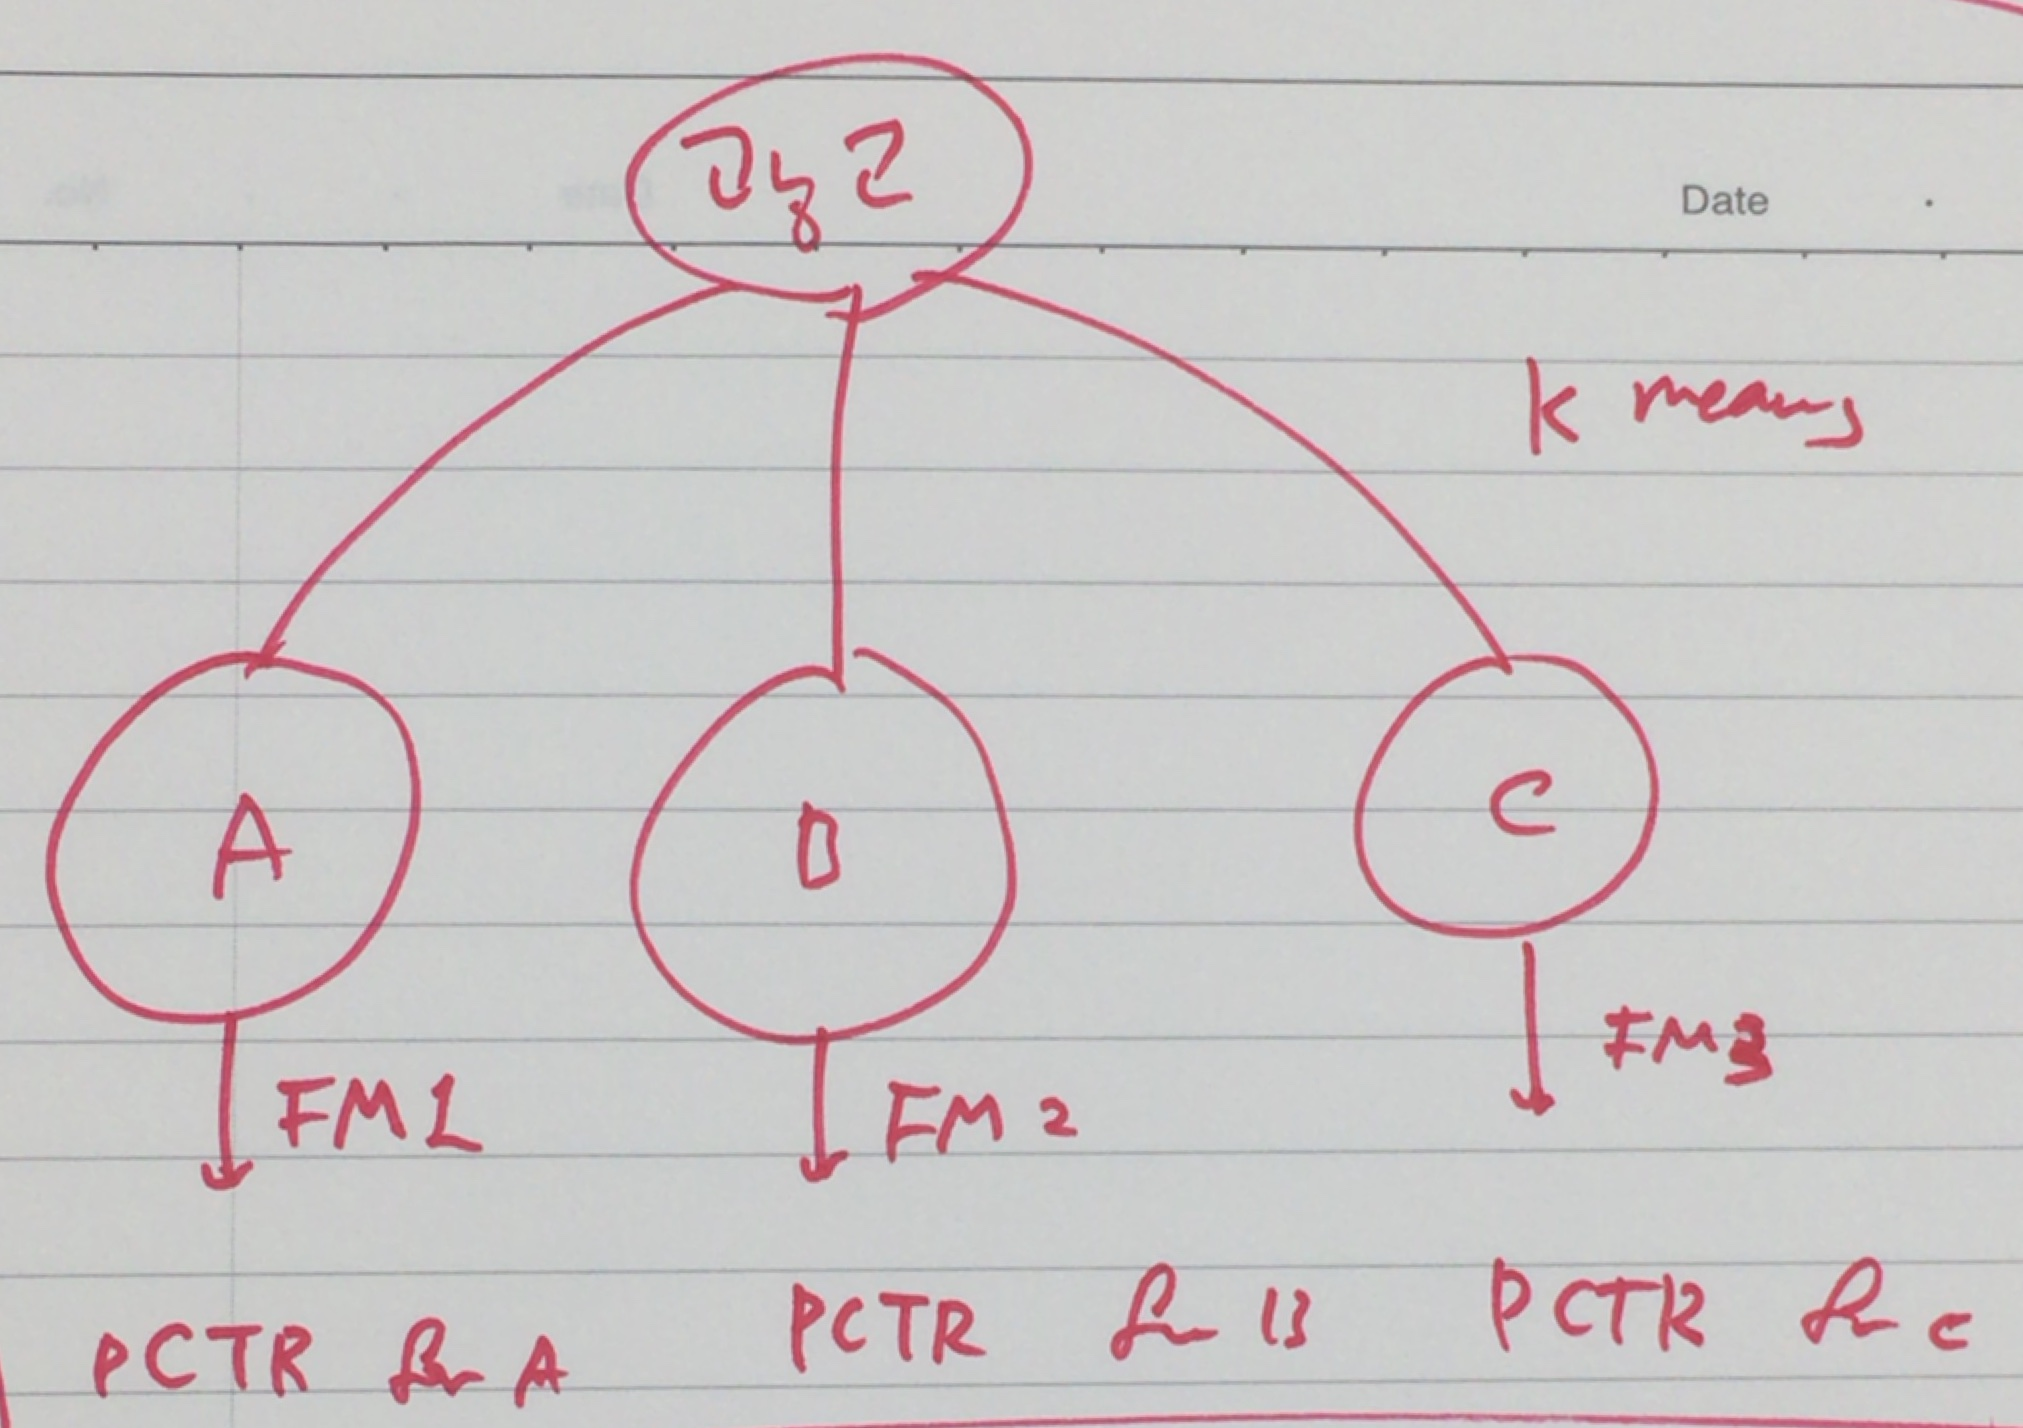

In [2]:
from fastFM.datasets import make_user_item_regression

num_of_users = 100 # 생성할 데이터의 user 수
num_of_items = 100 # 생성할 데이터의 item 수 (광고들)
for_imbalance = 223 #클래스 불균형을 만들기위한 수치. cf) 불균형 X: y.mean()

# ADtest1 = [{'user': i, 'AD': 'zAD0'} for i in col[:100]]
# ADtest2 = [{'user': 'user0', 'zAD': j} for j in col[100:]]
# from sklearn.feature_extraction import DictVectorizer
# v = DictVectorizer()
# X = v.fit_transform(ADtest1 + ADtest2)

# This sets up a small test dataset.
X, y, _ = make_user_item_regression(n_user=num_of_users, n_item=num_of_items)

# Convert dataset to binary classification task.
y_labels = np.ones_like(y)
y_labels[y < for_imbalance] = -1 
#print(y_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, random_state=77)
#print(X_train.toarray())


In [10]:
print(X[9990:])

  (0, 99)	1.0
  (1, 99)	1.0
  (2, 99)	1.0
  (3, 99)	1.0
  (4, 99)	1.0
  (5, 99)	1.0
  (6, 99)	1.0
  (7, 99)	1.0
  (8, 99)	1.0
  (9, 99)	1.0
  (0, 190)	1.0
  (1, 191)	1.0
  (2, 192)	1.0
  (3, 193)	1.0
  (4, 194)	1.0
  (5, 195)	1.0
  (6, 196)	1.0
  (7, 197)	1.0
  (8, 198)	1.0
  (9, 199)	1.0


In [81]:
# X_train and y_train in DataFrame
col = ['user{}'.format(i) for i in range(num_of_users)] \
+ ['AD{}'.format(i) for i in range(num_of_items)]
x_df = pd.DataFrame(X_train.toarray(), columns=col)
y_df = pd.Series(y_train,name='click')
df = pd.concat([y_df, x_df],axis=1)
print(df.shape)
print('cf) click: "+1=click, -1=unclick"')
df.head()

(7500, 201)
cf) click: "+1=click, -1=unclick"


,click,user0,user1,user2,user3,user4,user5,user6,user7,user8,...,AD90,AD91,AD92,AD93,AD94,AD95,AD96,AD97,AD98,AD99
0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
#CTR = number_of_+1/total_number_of_y 

print('[train] CTR = ', round(100*(y_train==1).sum()/len(y_train),2),'%')
print('[test] CTR  = ', round(100*(y_test==1).sum()/len(y_test),2),'%')


[train] CTR =  7.17 %
[test] CTR  =  7.36 %


In [83]:
# sparsity
print('sparsity: ',100*X_train.toarray().sum()/(7500*200), '%')

sparsity:  1.0 %


- Features :
    - 전체 x값들 중 1.0%만 값을 가지고 나머지는 전부 0이다. 데이터가 highly sparse하다.
    - 특징들은 크게 user와 AD(광고) 그룹으로 이루어져있다. CTR 예측에서는 둘 사이의 interaction을 고려해야한다.
    - 따라서, sparse한 데이터셋에서 interaction을 고려하기 용이한 FM을 사용하겠다.
- class : 
    - 전체 y값들 중 약 7~8%만 positive class(+1)이고 나머지는 negative class(-1)이다. 
    - 클래스 불균형이 심하다.
    - 비용민감모델/재샘플링을 적용하여 클래스 불균형 문제를 해결하겠다.
    

## 2.전처리 없이 FM으로 CTR 예측
- 실험의 대조군을 위해서 데이터에 대한 처리나 모델의 수정 없이 FM을 돌려서 CTR을 예측해보겠다.

In [106]:
from fastFM import sgd

# check time
start_time = time.time()

# fastFM = sgd.FMClassification(n_iter=1000, init_stdev=0.1, rank=2, step_size=0.02)
fastFM = sgd.FMClassification(n_iter=100000, init_stdev=0.1, l2_reg_w=0,\
                          l2_reg_V=0, rank=2, step_size=0.1)
fastFM.fit(X_train, y_train)

preds_fm = fastFM.predict(X_test)

print('--------------------')
print('Accuracy:', round(accuracy_score(y_test, preds_fm),3))
print('Precision: ', round(precision_score(y_test, preds_fm),3))
print('Recall: ', round(recall_score(y_test, preds_fm),3))
print('F1-score: ', round(f1_score(y_test, preds_fm),3))
print('CTR: ', 100*(preds_fm==1).sum()/len(preds_fm),'%')
# check time
print("--- %s seconds ---" % (time.time() - start_time))

--------------------
Accuracy: 0.985
Precision:  0.951
Recall:  0.842
F1-score:  0.893
CTR:  6.52 %
--- 0.023724079132080078 seconds ---


In [102]:
print('cf) [test set] CTR: ', 100*(y_test==1).sum()/len(y_test),'%')

cf) [test set] CTR:  7.36 %


- 데이터 자체가 FM를 테스트하기 위해 만들어진 데이터이다 보니 accuracy 자체가 상당히 잘 나오고, 클래스 불균형을 해결하지 않아도 F1-score이 크다.
- 하지만 그래도 불균형된 데이터이다 보니 accuracy나 precision에 비해서 recall과 F1-score이 낮게 나옴을 확인할 수 있다.
- 그리고 정답셋에 비해서 positve class의 비율인 CTR이 낮아짐을 확인할 수 있다.
    - 정답 CTR : 7.68%, 예측 CTR: 6.8%
- 데이터의 클래스불균형 문제를 해결하여 predicted CTR(pCTR)의 정확도를 높여보겠다.

# 3.비용민감모델로 pCTR 정확도 높이기
- 전략
    - fastFM 라이브러리에서는 classification이 될 확률을 계산하여 0과 1사이의 값으로 출력해주는 기능을 제공해주고 있다.
    - 확률로 예측값을 얻어내어 class가 나눠지는 threshold을 조정하여 FM을 비용민감모델로 만들어 본다. 
    - 가장 적절한 threshold를 구한다.

In [86]:
# probability 형태로도 예측 가능
#pred_prob = fastFM.predict_proba(X_test)
pred_prob = fastFM.predict_proba(X_train) # 일단 train으로 threshold 조정 후 test에 도입
pred_prob = minmax_scale(pred_prob)


In [87]:
#threshold
alpha_ls = [0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7]
acc_ls, prec_ls, recall_ls, f1_ls, ratio_ls = [], [], [], [], []
Nround=6

for alpha in alpha_ls:

    pred_proba = pred_prob.copy()
    
    #classification
    pred_proba[pred_proba < alpha] = -1
    pred_proba[pred_proba >= alpha] = 1
    
#     print('-------------')
#     print('alpha: ', alpha)
#     print('accuracy:', round(accuracy_score(y_test, pred_proba),Nround))
#     print('precision: ', round(precision_score(y_test, pred_proba),Nround))
#     print('recall: ', round(recall_score(y_test, pred_proba),Nround))
#     print('f1-score: ', round(f1_score(y_test, pred_proba),Nround))
#     print('raito: ', round(100*(pred_proba==1).sum()/len(pred_proba),Nround),'%')
    
#     acc_ls+=[round(accuracy_score(y_test, pred_proba),Nround)]
#     prec_ls+=[round(precision_score(y_test, pred_proba),Nround)]
#     recall_ls+=[round(recall_score(y_test, pred_proba),Nround)]
#     f1_ls+=[round(f1_score(y_test, pred_proba),Nround)]
#     ratio_ls+=[round(100*(pred_proba==1).sum()/len(pred_proba),Nround)]

    acc_ls+=[round(accuracy_score(y_train, pred_proba),Nround)]
    prec_ls+=[round(precision_score(y_train, pred_proba),Nround)]
    recall_ls+=[round(recall_score(y_train, pred_proba),Nround)]
    f1_ls+=[round(f1_score(y_train, pred_proba),Nround)]
    ratio_ls+=[round(100*(pred_proba==1).sum()/len(pred_proba),Nround)]

In [88]:
data = {'Threshold': alpha_ls, 'Accuracy':acc_ls, 'Precision':prec_ls, \
        'Recall':recall_ls, 'F1-score':f1_ls, 'Ratio':ratio_ls}
df_data = pd.DataFrame(data)
df_data

,Threshold,Accuracy,Precision,Recall,F1-score,Ratio
0,0.20,0.993467,0.929701,0.983271,0.955736,7.586667
1,0.25,0.994267,0.944345,0.977695,0.960731,7.426667
2,0.30,0.994800,0.956124,0.972119,0.964055,7.293333
3,0.35,0.994533,0.962756,0.960967,0.961860,7.160000
4,0.40,0.993867,0.964151,0.949814,0.956929,7.066667
5,0.45,0.993733,0.967619,0.944238,0.955786,7.000000
6,0.50,0.993733,0.984221,0.927509,0.955024,6.760000
7,0.55,0.992667,0.989858,0.907063,0.946654,6.573333
8,0.60,0.992133,0.993814,0.895911,0.942326,6.466667
9,0.65,0.991200,1.000000,0.877323,0.934653,6.293333


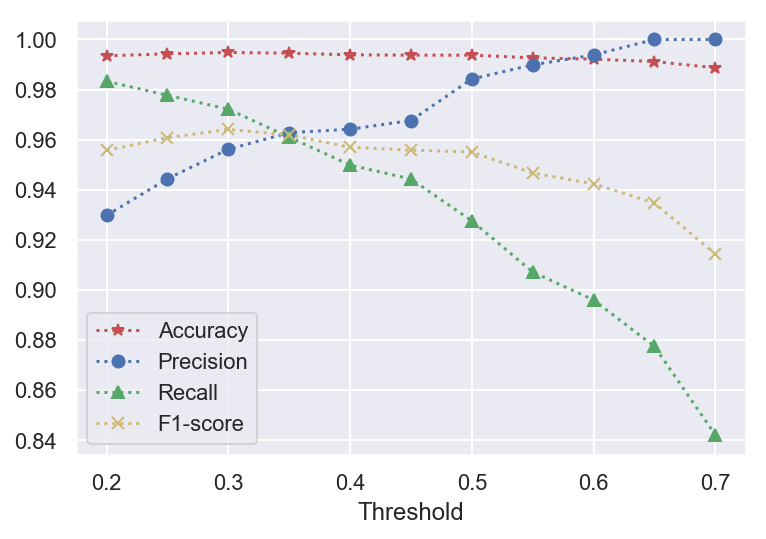

In [90]:
plt.plot(alpha_ls, acc_ls,'r*:', label='Accuracy') 
plt.plot(alpha_ls, prec_ls, 'bo:', label='Precision')
plt.plot(alpha_ls, recall_ls, 'g^:', label='Recall')
plt.plot(alpha_ls, f1_ls, 'yx:', label='F1-score')
plt.legend(loc=0)
plt.xlabel('Threshold')
plt.show()

- Threshold를 작게 만들어서 민감하게 만들 수록 recall은 커지는 반면에 precision은 작아진다.
    즉, negative class에 대한 정확도를 희생해서 positve class의 정확도를 올린 것.
- precision을 얼마나 희생하고 recall을 올릴 것인가의 문제가 있기 때문에 F1-score로 판단.
- F1-score은 threshold=0.3일 때가 가장 최대치. 그리고 이때 CTR(=#of+1/total)도 예측값과 정답이 7.68 동일해짐.
- 따라서 threshold=0.3으로 설정하여 FM을 비용민감모델로 만든다면 정확한 CTR값을 예측할 수 있다.

In [98]:
threshold = df_data[df_data['F1-score'] == max(df_data['F1-score'])]['Threshold'].iloc[0]
df_data[df_data['F1-score'] == max(df_data['F1-score'])]

,Threshold,Accuracy,Precision,Recall,F1-score,Ratio
2,0.3,0.9948,0.956124,0.972119,0.964055,7.293333


In [105]:
pred_proba_test = fastFM.predict_proba(X_test)
pred_proba_test = minmax_scale(pred_proba_test)
pred_proba_test[pred_proba_test < threshold] = -1
pred_proba_test[pred_proba_test >= threshold] = 1
    
print('--------------------')
print('accuracy:', round(accuracy_score(y_test, pred_proba_test),Nround))
print('precision: ', round(precision_score(y_test, pred_proba_test),Nround))
print('recall: ', round(recall_score(y_test, pred_proba_test),Nround))
print('f1-score: ', round(f1_score(y_test, pred_proba_test),Nround))
print('ratio: ', round(100*(pred_proba_test==1).sum()/len(pred_proba_test),Nround),'%')
print('--------------------')

--------------------
accuracy: 0.9876
precision:  0.942197
recall:  0.88587
f1-score:  0.913165
ratio:  6.92 %
--------------------


**비용민감모델 적용 전**
- Accuracy: 0.985
- Precision:  0.951
- Recall:  0.842
- F1-score:  0.893
- CTR:  6.52 %

In [115]:
'''
cf)
(0, 109) 1.0 : AD(100부터 시작)의 9번째 인덱스에 1 = AD9
(0, 17) 1.0 : user의 17번째 인덱스에 1 = user17
'''
print(X_train[1]) 

  (0, 109)	1.0
  (0, 17)	1.0


In [170]:
a, b, _ = make_user_item_regression(n_user=num_of_users, n_item=1)

In [178]:
test = a[:100]

In [179]:
print(test.toarray())

[[1. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 1.]]


In [180]:
aaa = fastFM.predict_proba(test)
# pred_proba_test = minmax_scale(pred_proba_test)
# pred_proba_test[pred_proba_test < threshold] = -1
# pred_proba_test[pred_proba_test >= threshold] = 1

AssertionError: 

In [154]:
print(ADtest_vec)

  (0, 0)	1.0
  (0, 1)	1.0
  (1, 0)	1.0
  (1, 2)	1.0
  (2, 0)	1.0
  (2, 13)	1.0
  (3, 0)	1.0
  (3, 24)	1.0
  (4, 0)	1.0
  (4, 35)	1.0
  (5, 0)	1.0
  (5, 46)	1.0
  (6, 0)	1.0
  (6, 57)	1.0
  (7, 0)	1.0
  (7, 68)	1.0
  (8, 0)	1.0
  (8, 79)	1.0
  (9, 0)	1.0
  (9, 90)	1.0
  (10, 0)	1.0
  (10, 3)	1.0
  (11, 0)	1.0
  (11, 4)	1.0
  (12, 0)	1.0
  :	:
  (187, 187)	1.0
  (188, 1)	1.0
  (188, 188)	1.0
  (189, 1)	1.0
  (189, 189)	1.0
  (190, 1)	1.0
  (190, 191)	1.0
  (191, 1)	1.0
  (191, 192)	1.0
  (192, 1)	1.0
  (192, 193)	1.0
  (193, 1)	1.0
  (193, 194)	1.0
  (194, 1)	1.0
  (194, 195)	1.0
  (195, 1)	1.0
  (195, 196)	1.0
  (196, 1)	1.0
  (196, 197)	1.0
  (197, 1)	1.0
  (197, 198)	1.0
  (198, 1)	1.0
  (198, 199)	1.0
  (199, 1)	1.0
  (199, 200)	1.0


In [151]:
ADtest_vec.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 4.재샘플링으로 클래스 불균형 문제 해결하기